In [6]:
import pandas as pd
import numpy as np
import scipy as sp
from cvxpy import *
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline

print("Current environment directory:" + sys.prefix)
print("System version: "+sys.version)
print("Current working directory: "+os.getcwd())

Current environment directory:/Users/emunsing/GoogleDrive/Papers/GridStructureEstimation/Coding/Python/env/bin/..
System version: 2.7.12 (default, Aug 23 2016, 08:54:23) 
[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]
Current working directory: /Users/emunsing/GoogleDrive/Papers/GridStructureEstimation/Coding/Python


In [35]:
inputData = pd.read_csv('../../Data/MatlabData/24h_MCC.csv',header=None).transpose()  #Result: time in columns, nodes in rows
print(inputData.shape)
inputData.head()

(14, 288)


,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
0,0.00000,0.000000,0.0000,0.00000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00000,0.00000,0.0000
1,4.68750,4.230400,12.8050,0.66288,1.0375,9.3794,1.94240,10.9600,10.5870,8.5702,...,5.9019,8.5661,6.0424,9.4003,10.9290,8.3888,12.7030,0.39474,1.84720,5.2799
2,13.90200,13.759000,13.3930,10.27400,17.5240,15.6490,7.46160,19.7190,16.6210,15.4820,...,13.6440,17.1500,8.4339,16.6970,12.1670,14.1980,17.2460,6.75450,8.40360,11.7000
3,0.35454,0.119540,9.6592,-2.71550,-5.5367,5.1335,-0.23246,4.9398,5.8953,4.4323,...,1.9912,3.0983,4.2619,5.1583,8.4051,4.3655,8.5165,-2.18410,-0.51273,1.8880
4,0.48719,-0.047588,8.6480,-2.49870,-3.9108,4.5292,-0.42730,5.1726,5.5714,3.6974,...,1.6627,3.6071,3.2016,4.0317,6.9284,4.0762,7.2162,-1.48800,-0.89017,1.6779


In [213]:
## Trim data down to a usable size
endBus = 5
endTimeIdx = 25
L = inputData.iloc[1:endBus,:endTimeIdx].values
(n,t) = L.shape       # t: time steps,  n: number of nodes
print(L.shape)

## Setting up for solving the problem

O = np.ones([n,n]) - np.eye(n)  # Off-diagonal matrix, dim n*n   (O := 1 1' - I)

# Tuning parameters: Weights in minimization
k1 = 1e-3  # This set is Kekatos' experimentally determined coefficients
k2 = 5e-4
k3 = 1e-2
k4 = 1e-1

(4, 25)


In [221]:
B = Semidef(n)
S = Variable(n,t)
obj = Minimize( 1/2. * sum_squares(B * L - S) +  # Least-squares fitting to data in L
               k1*norm(mul_elemwise(O, B), 1) +             # Make B sparse off-diagonal 
               k2*norm(S,1) +                  # Make S sparse
               k3*norm(S,'nuc') -              # Encourage a low-rank solution of S
               k4*log_det(B) )                 # Ensure B positive definite and nonzero

constraints = [mul_elemwise(O, B) <= 0]

prob = Problem(obj,constraints)

result = prob.solve(verbose=True, max_iters = 7000)
print("Solved!")

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 2585, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 7000, normalize = 1, scale = 1.00
Variables n = 1128, constraints m = 1423
Cones:	primal zero / dual free vars: 570
	linear vars: 248
	soc vars: 102, soc blks: 1
	sd vars: 491, sd blks: 4
	exp vars: 12, dual exp vars: 0
Setup time: 2.61e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  2.12e-02 
   100| 1.53e-01  1.17e-01  3.60e-02  1.07e+00  9.64e-01  2.67e-15  1.71e-01 
   200| 3.40e-02

Inferred B matrix:
[[ 1.06 -0.32 -0.18 -0.56]
 [-0.32  0.29 -0.   -0.  ]
 [-0.18 -0.    2.43 -2.16]
 [-0.56 -0.   -2.16  3.57]]


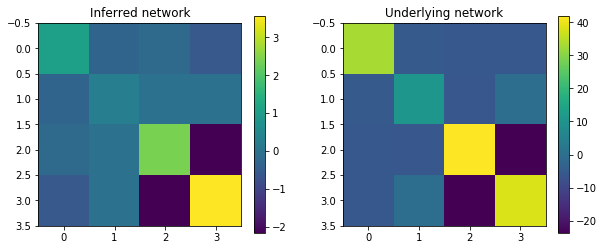

In [217]:
## Plot results and compare with actual

B_true = np.genfromtxt('../../Data/MatlabData/B_true_13bus.csv', delimiter=',')

print("Inferred B matrix:")
print(np.round(B.value,2))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(B.value)
plt.colorbar()
plt.title('Inferred network')

plt.subplot(1,2,2)
plt.imshow(B_true[0:endBus-1,0:endBus-1])
plt.colorbar()
plt.title('Underlying network')

## Notes on cvxpy:

**Expressions**: For any expression, can get size with (expr).size and value with (expr).value

## Notes on Numpy:
1-d numpy arrays have ambiguous dimensions: can be used as either row vector or column vector. 
- multiplication of arrays by default is elementwise.  Need to use np.dot() to get the true dot product.
- Np.dot will reorient vectors to get what it thinks is the desired result. 

# To-do:
- The Python implementation appears to produce more reasonable-looking results than the Matlab implementation
- **What can be leading to this?** Likely an issue with objective fcn or solver
- Double-check that each part of the objective function is working properly with the B and S matrices that were computed in Matlab vs. Python
- Check different solvers in Python

Debugging:
- Objective function of the Python implementation is different than the objective function of the Matlab implementation.
- L is the same between the two

Values of using the Matlab data in each implementation:

| Term           | Python    |  Matlab  |Check|
|----------------|-----------|----------|-----|
| Sum of squares |  1.544e-4 | 1.544e-4 | ok  |
| Norm O,B       | 1.0985e-14| 4.9673e-15 | meh|
| S 1-norm       | .126047 | 0.0106 | BAD |
| S nuclear norm | 0.38905 | 0.3890 | ok  |
| log det B      | -0.3165 | -0.3165| ok  |

So there's a difference in how Matlab and Cvxpy are implementing the 1-norm

### CVXPY and CVX use different p-norms for matrices!
CVX uses the induced matrix norm, while CvxPy treats the matrix as a vector, and uses the vector norm!

This means that the 1-norm in CVX is the maximum absolute column sum... while the 1-norm in CvxPy is the sum of the absolute values of the entries!

This is a ***huge*** difference! Need to look at how the paper intends to implement this.

**Kekatos uses the vector-norm, not the induced matrix norm!**
See page 2, last paragraph before section II.

### Second bugfix: Slightly different optima; fixed by removing the `B >=0` constraint in CVX

Results are close, but not quite the same... same general structure, slightly different graphs. Unclear what is creating this difference.


In [211]:
## Debugging Matlab solvers

B_mat = np.genfromtxt('../Matlab/B_n4t25.csv', delimiter=',')
S_mat = np.genfromtxt('../Matlab/S_n4t25.csv', delimiter=',')

B_mat = np.matrix(B_mat)
S_mat = np.matrix(S_mat)

# obj = Minimize( 1/2. * sum_squares(B * L - S) +  # Least-squares fitting to data in L
#               k1*norm(mul_elemwise(O, B), 1) +             # Make B sparse off-diagonal 
#               k2*norm(S,1) +                  # Make S sparse
#               k3*norm(S,'nuc') -              # Encourage a low-rank solution of S
#               k4*log_det(B) )                 # Ensure B positive definite and nonzero
